In [1]:
from bioio import BioImage
from matplotlib import pyplot as plt
import numpy as np
import skimage
from scipy import stats, ndimage
import math
import csv
import random
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [2]:
# Path to image
image_file = ("..\\data\\Day 1 adult animals\\D1A_rep 3.nd2")

# Create a BioImage reader
reader = BioImage(image_file)

# Get number of z-planes
size_z = reader.shape[2]

image = reader.get_image_data("YXC", Z=3)


In [3]:
sam2_checkpoint = "inc/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
# Preprocess the image - SAM2 expects RGB images in the range [0 1]

image_processed = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
for z in range(image.shape[2]):
    curr_slice = image[:, :, z].astype(np.float32)
    curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
    image_processed[:, :, z] = curr_slice

plt.imshow(image_processed)

In [ ]:
predictor.set_image(image_processed)

In [ ]:
bbox = np.array([0, 0, 700, 600])  #[left, top, right, bottom]

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox,
    multimask_output=True,
)

plt.imshow(masks[0, :, :])




In [ ]:
print(scores)

In [ ]:
# Or is it better to just use the green channel?

image_processed = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
curr_slice = image[:, :, 1].astype(np.float32)
curr_slice = skimage.filters.gaussian(curr_slice, 1)

curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
#curr_slice = skimage.exposure.adjust_sigmoid(curr_slice)

image_processed[:, :, 1] = curr_slice

predictor.set_image(image_processed)

bbox = np.array([0, 0, 700, 600])  #[left, top, right, bottom]

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox,
    multimask_output=True,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]

best_mask = masks[:, :, 0]


In [ ]:
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]

best_mask = masks[0, :, :]

plt.imshow(best_mask)

In [6]:
# Auto-segment the tail by first using thresholding to identify the tail
combined_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
for z in range(image.shape[2]):
    curr_slice = image[:, :, z].astype(np.float32)
    curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
    combined_image[:, :, z] = curr_slice

combined_image_gray = skimage.color.rgb2gray(combined_image)

# Clean the image by subtracting the background
combined_image_cleaned = skimage.filters.gaussian(combined_image_gray, 1)

# Generate the mask using a convex hull
thLvl = skimage.filters.threshold_li(combined_image_cleaned)
mask_tail = combined_image_cleaned > (0.9 * thLvl)
mask_tail = ndimage.binary_fill_holes(mask_tail)
mask_tail = skimage.morphology.remove_small_objects(mask_tail, 500)
mask_tail = skimage.morphology.binary_opening(mask_tail, skimage.morphology.disk(4))





1
(43, 0, 643, 704)


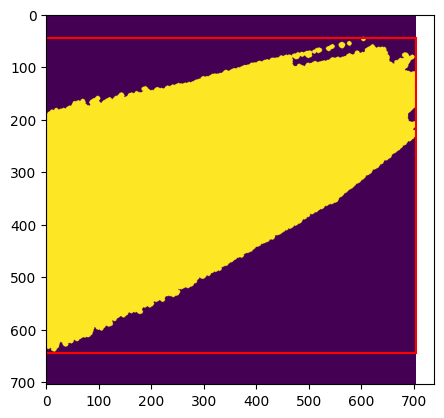

In [7]:
tail_labels = mask_tail.astype(int)

props = skimage.measure.regionprops(tail_labels)

print(len(props))
print(props[0].bbox)

plt.clf()
plt.imshow(mask_tail)
plt.plot([props[0].bbox[1], props[0].bbox[3]], [props[0].bbox[0], props[0].bbox[0]], c='red')
plt.plot([props[0].bbox[1], props[0].bbox[3]], [props[0].bbox[2], props[0].bbox[2]], c='red')
plt.plot([props[0].bbox[1], props[0].bbox[1]], [props[0].bbox[0], props[0].bbox[2]], c='red')
plt.plot([props[0].bbox[3], props[0].bbox[3]], [props[0].bbox[0], props[0].bbox[2]], c='red')
plt.show()


In [22]:
image_processed = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
curr_slice = image[:, :, 1].astype(np.float32)
curr_slice = skimage.filters.gaussian(curr_slice, 1)

curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
#curr_slice = skimage.exposure.adjust_sigmoid(curr_slice)

image_processed[:, :, 1] = curr_slice

predictor.set_image(image_processed)

#bbox = np.array([0, 0, 700, 600])  #[left, top, right, bottom]

bbox = np.array([props[0].bbox[1], props[0].bbox[0], props[0].bbox[3], props[0].bbox[2]])  #[left, top, right, bottom]

# Increase the bbox a little, but clamp it to the size of the image
px_increase = 20

bbox[0] = np.clip(bbox[0] - px_increase, 0, None)
bbox[1] = np.clip(bbox[1] - px_increase, 0, None)
bbox[2] = np.clip(bbox[2] + px_increase, None, image.shape[1])
bbox[3] = np.clip(bbox[3] + px_increase, None, image.shape[0])

print(bbox)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox,
    multimask_output=True,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]

best_mask = masks[0, :, :]
print(scores)

[  0  23 704 663]
[0.98558575 0.8944993  0.8827308 ]


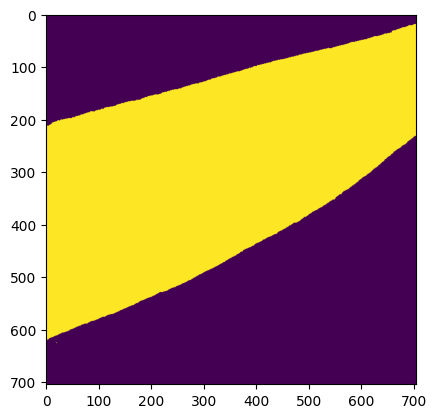

In [23]:
plt.imshow(masks[0, :, :])

In [24]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours = skimage.segmentation.find_boundaries(mask)
        mask_image[contours, :] = 1 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

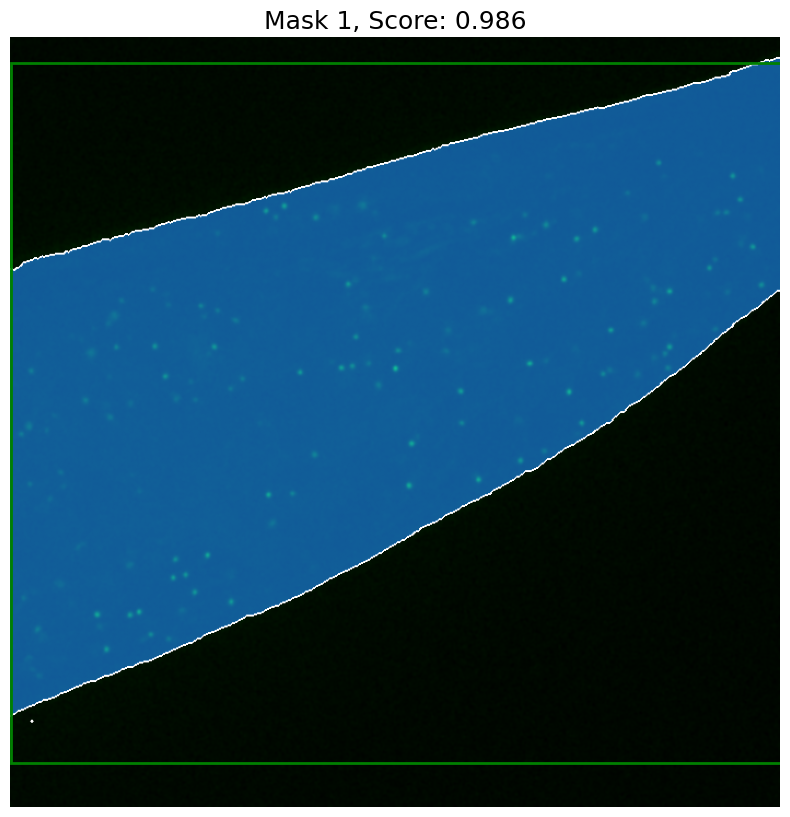

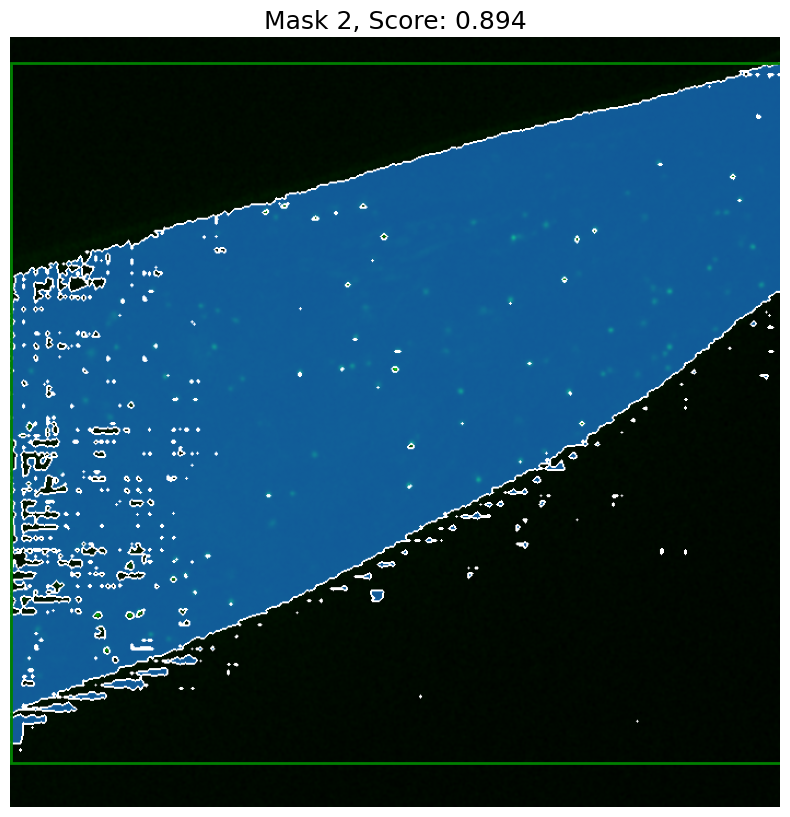

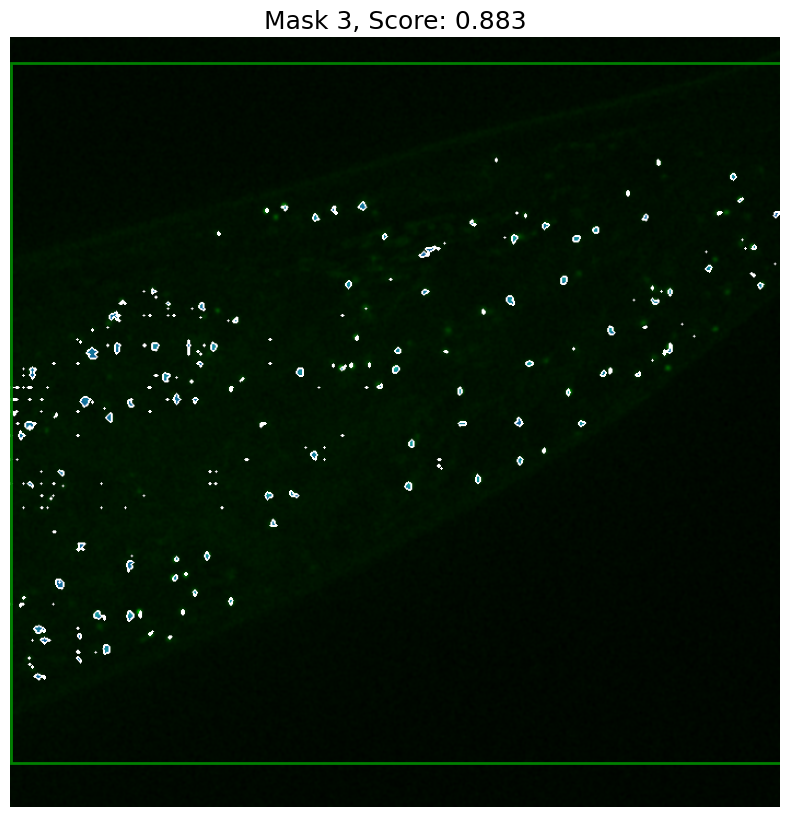

In [25]:
show_masks(image_processed, masks, scores, box_coords=bbox)
